#### Import các thư viện cần thiết

In [11]:
import ultralytics
ultralytics.checks()

import os
import numpy as np
import timm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

from ultralytics import YOLO

Ultralytics 8.3.56  Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)


Setup complete  (16 CPUs, 7.7 GB RAM, 90.1/117.2 GB disk)


#### Load mô hình

In [12]:
# text detection: 
text_det_model_path = '../weights/best.pt'
yolo = YOLO(text_det_model_path)

In [13]:
# text Recognition
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet34", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x
    
chars = '0123456789abcdefghijklmnopqrstuvwxyz-'
vocab_size = len(chars)
char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {index: char for char, index in char_to_idx.items()}

hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = '../weights/crnn.pt'
crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)
crnn_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None

        for token in seq:
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char
        decoded_sequences.append(''.join(decoded_label))
    print(f'From {encoded_sequences} to {decoded_sequences}')
    return decoded_sequences

#### Hàm Text Detection

In [15]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]
    bboxes = text_det_results.boxes.xyxy.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()
    return bboxes, classes, names, confs

#### Hàm nhận diện văn bản

In [16]:
def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()
    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()
    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)
    return text

#### Hàm trực quan hóa kết quả

In [17]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(
            x1, y1-10, f'{detected_class} ({confidence:.2f}): {transcribed_text}',
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )

In [18]:
data_transforms = {
    'train': transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1, 
                shear=1
            ),
            transforms.RandomPerspective(
                distortion_scale=0.3,
                p=0.5, 
                interpolation=3
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]
    ),
    'val': transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]
    )
}

In [19]:
def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device):
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    img = Image.open(img_path)

    predictions = []

    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        cropped_image = img.crop((x1, y1, x2, y2))
        transcribed_text = text_recognition(
            cropped_image, 
            data_transforms, 
            text_reg_model, 
            idx_to_char, 
            device
        )

        predictions.append((bbox, name, confidence, transcribed_text))
    visualize_detections(img, predictions)
    return predictions

From tensor([[ 1,  1, 14,  1, 23,  1,  1, 32, 32, 20,  1, 13,  1,  1]]) to ['cluib']
From tensor([[ 1, 15,  1, 26,  1, 23,  1, 23,  1, 12, 12, 29, 29,  1]]) to ['dollar']
From tensor([[ 1, 18, 18,  1, 26, 26,  1, 23, 23,  1,  1, 17, 17,  1]]) to ['golf']
From tensor([[ 1,  1,  1, 12,  1,  1, 15,  1,  1, 31, 31,  1,  1,  1]]) to ['adt']


[([432.54351806640625,
   196.10696411132812,
   546.84716796875,
   251.05572509765625],
  'text',
  0.8833062052726746,
  ['cluib']),
 ([122.94070434570312,
   201.1954345703125,
   304.6707763671875,
   253.42462158203125],
  'text',
  0.8821434378623962,
  ['dollar']),
 ([316.35931396484375,
   203.95277404785156,
   421.62982177734375,
   254.32505798339844],
  'text',
  0.8738019466400146,
  ['golf']),
 ([87.1705322265625,
   90.06375122070312,
   111.76432800292969,
   137.85272216796875],
  'text',
  0.7390985488891602,
  ['adt'])]

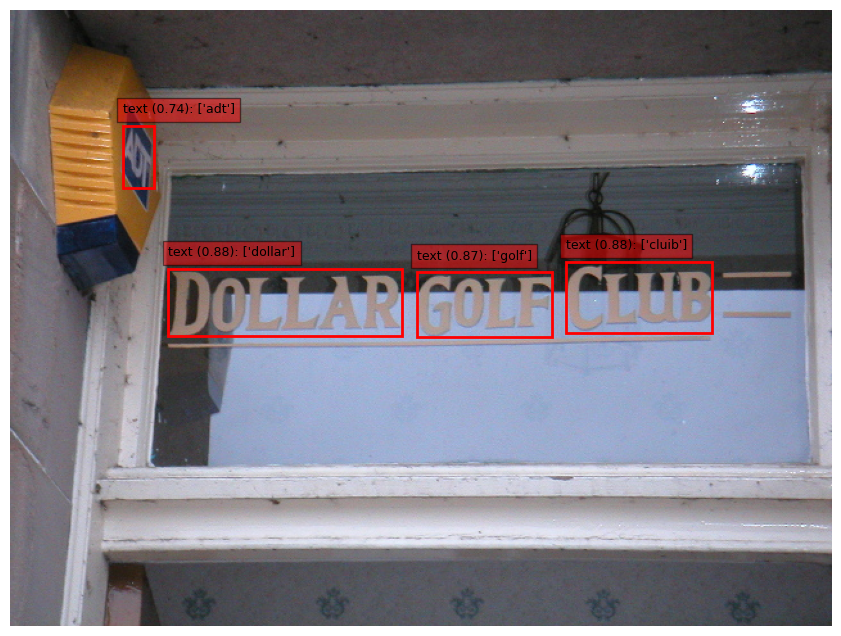

In [20]:
predict(
    'E:/AIO_document/AIO2024/AIO2024-Project/scene-text-recognition-PM06-AIO2024/src/datasets/SceneTrialTrain/ryoungt_03.09.2002/PICT0030.JPG',
    data_transforms['val'],
    text_det_model=yolo,
    text_reg_model=crnn_model,
    idx_to_char=idx_to_char, 
    device=device
)